In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set(style='whitegrid', palette='muted')

import json
import utils
import os

In [65]:
with open(os.path.join(utils.TRACE_DIR,"platform1/direct_tensors/chain-2", "servetrace torch: BS:1 [224x224x3].json" )) as f:
    data = json.load(f)

In [77]:
def derive_dataframes(df, router_name):
    router_df = df.loc[df["router_name"] == router_name].drop("router_name",1)
    return router_df.pivot(index='query_id', columns="event").droplevel(0,axis=1)

def get_metadata_df(metadata, router_name):
    metadata_router_df = pd.DataFrame(metadata[router_name]).drop("backend")
    return metadata_router_df.transpose().rename_axis("query_id")


warmup_phase = list(range(1,200))
df = pd.DataFrame(data['traces'])
up_df = derive_dataframes(df, "up").drop(index=warmup_phase)
down_df = derive_dataframes(df, "down").drop(index=warmup_phase)
print(up_df.head())
down_df.head()
# down_metadata = pd.DataFrame(data['metadata']["down"])
# down_metadata.head()
metadata_down_df = get_metadata_df(data['metadata'], "down").drop("batch_id", 1).reset_index("query_id")
metadata_up_df = get_metadata_df(data['metadata'], "up").drop("batch_id", 1).reset_index("query_id")
metadata_df = pd.merge(metadata_up_df, metadata_down_df, how="inner", on="pipeline-id", suffixes=["_up", "_down"])
metadata_df

event       router_dequeue    router_enqueue  router_recv_result  \
query_id                                                           
200       1598364412013383  1598364412011533    1598364412018547   
201       1598364412040387  1598364412037562    1598364412045023   
202       1598364412068270  1598364412064821    1598364412073200   
203       1598364412093811  1598364412092014    1598364412098458   
204       1598364412119982  1598364412117600    1598364412125363   

event          worker_done      worker_start  
query_id                                      
200       1598364412015074  1598364412014930  
201       1598364412042113  1598364412041954  
202       1598364412070175  1598364412070013  
203       1598364412095531  1598364412095387  
204       1598364412122258  1598364412122112  


,query_id_up,pipeline-id,query_id_down
0,1,0,1
1,2,1,2
2,3,2,3
3,4,3,4
4,5,4,5
...,...,...,...
1995,1996,1995,1996
1996,1997,1996,1997
1997,1998,1997,1998
1998,1999,1998,1999


In [73]:
event_ordering = [
    "router_enqueue",
    "router_dequeue",
    "worker_start",
    "worker_done",
    "router_recv_result"
]



In [78]:
def get_event_differences(df, event_ordering):
    series = {}
    for e_start, e_end in zip(event_ordering, event_ordering[1:]):
        series[f"{e_start}->{e_end}"] = df[e_end] - df[e_start]
    diff_df = pd.DataFrame(series)
    return diff_df
up_diff = get_event_differences(up_df, event_ordering)
down_diff = get_event_differences(down_df, event_ordering)

In [85]:
# up
def plot_df_diff(diff_df, title):
    for name, s in diff_df.T.iterrows():
        sns.distplot(s, label=name, kde_kws={"cumulative": True})
    plt.legend()
    plt.xlabel("us")
    plt.title(title)

,router_enqueue->router_dequeue,router_dequeue->worker_start,worker_start->worker_done,worker_done->router_recv_result
query_id,,,,
200,1850,1547,144,3473
201,2825,1567,159,2910
202,3449,1743,162,3025
203,1797,1576,144,2927
204,2382,2130,146,3105


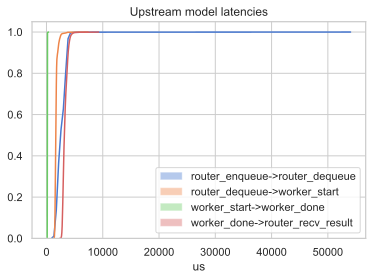

In [86]:
# up
plot_df_diff(up_diff, "Upstream model latencies")
up_diff.head()


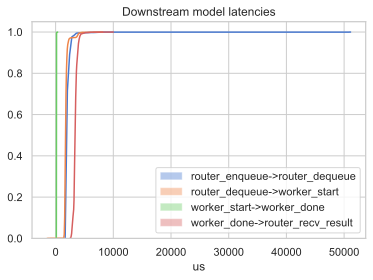

In [87]:
# down
plot_df_diff(down_diff, "Downstream model latencies")


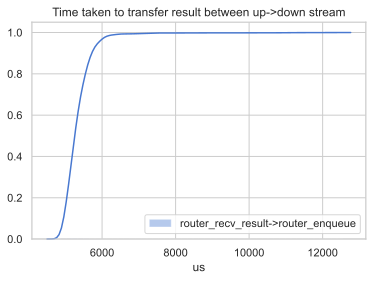

In [88]:
pipe_df = pd.concat([up_df[event_ordering[-1]], down_df[event_ordering[0]]], axis=1)
pipe_diff = get_event_differences(pipe_df, [event_ordering[-1], event_ordering[0]])

plot_df_diff(pipe_diff, "Time taken to transfer result between up->down stream")
